# Churn Analysis

Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months

### Columns:

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.


employee_id : id of the employee. Unique by employee per company <br>
company_id : company id <br>
dept : employee dept <br>
seniority : number of yrs of work experience when hired <br>
salary: avg yearly salary of the employee during her tenure ithin the company <br>
join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 <br>
quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

### Question:

1. What are the main factors that drive employee churn? 

2. What is the most important variable that could help explain employee churn? If the most important variable is not present in the dataset already, then this would explain the importance of data engineering.

In [82]:
% matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import datetime as dt

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import roc_auc_score, roc_curve, auc

## Load data

In [3]:
data = pd.read_csv("./data/employee_retention_data.csv")
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.count()

employee_id    24702
company_id     24702
dept           24702
seniority      24702
salary         24702
join_date      24702
quit_date      13510
dtype: int64

In [5]:
data.count() / len(data)

employee_id    1.000000
company_id     1.000000
dept           1.000000
seniority      1.000000
salary         1.000000
join_date      1.000000
quit_date      0.546919
dtype: float64

45.3% missing data implies that the those employees are still working for the company. So lets add a separate column "job_status" to identify/filter the employees easily.

## Data exploration and Feature Engineering

In [6]:
data['job_status'] = 1 # still working
data.loc[data['quit_date'].notnull(), 'job_status'] = 0 # Quit

__Data Engineering - add columns that might be helpful for the analysis__

In [7]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

data['duration_days'] = data['quit_date'] - data['join_date']
data['duration_years'] = [x.days/365 for x in data['duration_days']]

In [8]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585 days,1.602740
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340 days,0.931507
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,1,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389 days,1.065753
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040 days,2.849315


__Unique departments in the dataset__

In [9]:
print(data.dept.unique())

['customer_service' 'marketing' 'data_science' 'engineer' 'sales' 'design']


__Seniority__

In [10]:
print(sorted(data['seniority'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 98, 99]


Oops! There are people with 98 and 99 years of experience when joined. Impossible!! So lets drop those rows.

In [11]:
data = data[data['seniority']<50]

In [12]:
data.shape

(24700, 10)

### Max salary:

In [13]:
data.salary.max()

408000.0

In [14]:
data[data.salary > 375000]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years
3172,965750.0,1,data_science,19,398000.0,2015-05-04,NaT,1,NaT,NaN
4150,707585.0,1,engineer,22,393000.0,2013-09-16,NaT,1,NaT,NaN
4432,324366.0,2,data_science,26,381000.0,2014-12-17,NaT,1,NaT,NaN
6638,460908.0,1,engineer,24,386000.0,2014-11-03,NaT,1,NaT,NaN
7487,807316.0,1,data_science,20,377000.0,2015-10-26,NaT,1,NaT,NaN
7919,517439.0,2,engineer,25,406000.0,2013-09-16,NaT,1,NaT,NaN
8823,820823.0,1,data_science,23,381000.0,2014-11-03,NaT,1,NaT,NaN
10689,62540.0,2,engineer,23,408000.0,2013-08-26,NaT,1,NaT,NaN
12496,921637.0,1,engineer,16,379000.0,2012-09-17,2015-09-25,0,1103 days,3.021918
19941,899310.0,2,data_science,22,376000.0,2014-08-11,NaT,1,NaT,NaN


Not impossible as many of the employees in silicon valley are getting huge salary package.

### Min salary:

In [15]:
data.salary.min()

17000.0

In [16]:
data[data.salary < 20000]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years
2156,793589.0,3,customer_service,4,19000.0,2014-01-27,NaT,1,NaT,NaN
2483,16444.0,3,customer_service,2,18000.0,2015-03-02,NaT,1,NaT,NaN
2750,582569.0,12,customer_service,3,18000.0,2011-05-16,2012-05-04,0,354 days,0.969863
4107,813428.0,8,customer_service,1,17000.0,2011-10-31,2012-10-12,0,347 days,0.950685
4437,881886.0,7,customer_service,4,19000.0,2011-11-28,2013-09-13,0,655 days,1.794521
4686,829564.0,9,customer_service,2,19000.0,2013-11-04,NaT,1,NaT,NaN
7159,966857.0,4,customer_service,4,19000.0,2015-06-01,NaT,1,NaT,NaN
7460,603139.0,4,customer_service,1,19000.0,2014-03-24,2015-01-02,0,284 days,0.778082
9170,71029.0,5,customer_service,1,18000.0,2013-06-12,NaT,1,NaT,NaN
10255,808516.0,12,customer_service,3,18000.0,2012-11-12,2013-10-25,0,347 days,0.950685


On the other end we also have people who are getting much less data. These are employees with minimal years of experience or starting their career after graduation or even switiching the field from one technology to the other in which case they may have to start over with low base salary.

# Churn-rate plots:
Company headcount on each day since 2011/01/23 (assume the headcount start at 0)

In [17]:
data_headcount = data[['company_id', 'join_date', 'quit_date']].copy(deep=True)

Adding "end_date" to compute headcount. end_date = quit_date if the employee has quit otherwise our reference date "2015/12/13"

In [18]:
data_headcount['end_date'] = data_headcount['quit_date']
data_headcount.loc[data_headcount['quit_date'].isnull(), 'end_date'] = pd.to_datetime("2015/12/13")

Columns requiredto calculate headcount - company_id, day, headcount

In [19]:
data_headcount.head()

,company_id,join_date,quit_date,end_date
0,7,2014-03-24,2015-10-30,2015-10-30
1,7,2013-04-29,2014-04-04,2014-04-04
2,4,2014-10-13,NaT,2015-12-13
3,7,2012-05-14,2013-06-07,2013-06-07
4,2,2011-10-17,2014-08-22,2014-08-22


In [20]:
data_headcount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24700 entries, 0 to 24699
Data columns (total 4 columns):
company_id    24700 non-null int64
join_date     24700 non-null datetime64[ns]
quit_date     13508 non-null datetime64[ns]
end_date      24700 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(1)
memory usage: 964.8 KB


All the dates are already in datetime format

### Compute headcount

In [21]:
company_headcount = {}
for i, group in data_headcount.groupby('company_id'):
    print("Working on company_id: %d" %i)
    
    dff = pd.DataFrame()
    for j, rows in group.iterrows():
        df = pd.DataFrame(pd.date_range(rows['join_date'], rows['end_date']).value_counts().astype(np.bool), columns=[i])
        dff = pd.concat([df, dff], axis=1)
        dff['head_count'] = dff.sum(axis=1)
        dff = dff[['head_count']]
        
    company_headcount[i] = dff

Working on company_id: 1
Working on company_id: 2
Working on company_id: 3
Working on company_id: 4
Working on company_id: 5
Working on company_id: 6
Working on company_id: 7
Working on company_id: 8
Working on company_id: 9
Working on company_id: 10
Working on company_id: 11
Working on company_id: 12


__Save the files__

In [22]:
if not os.path.isdir("./head_count/"):
    os.mkdir("./head_count/")

## write
for i, dat in company_headcount.items():
    dat.to_excel("./head_count/hc_company_%s.xlsx" %str(i))

In [23]:
def get_dict_label(x):
    return re.split('[^A-Za-z0-9]+', x)[2]

company_headcount = {}
for file in os.listdir("./head_count/"):
    label = get_dict_label(file)
    company_headcount[int(label)] = pd.read_excel("./head_count/" + file)

# Company headcount from 2011-2016

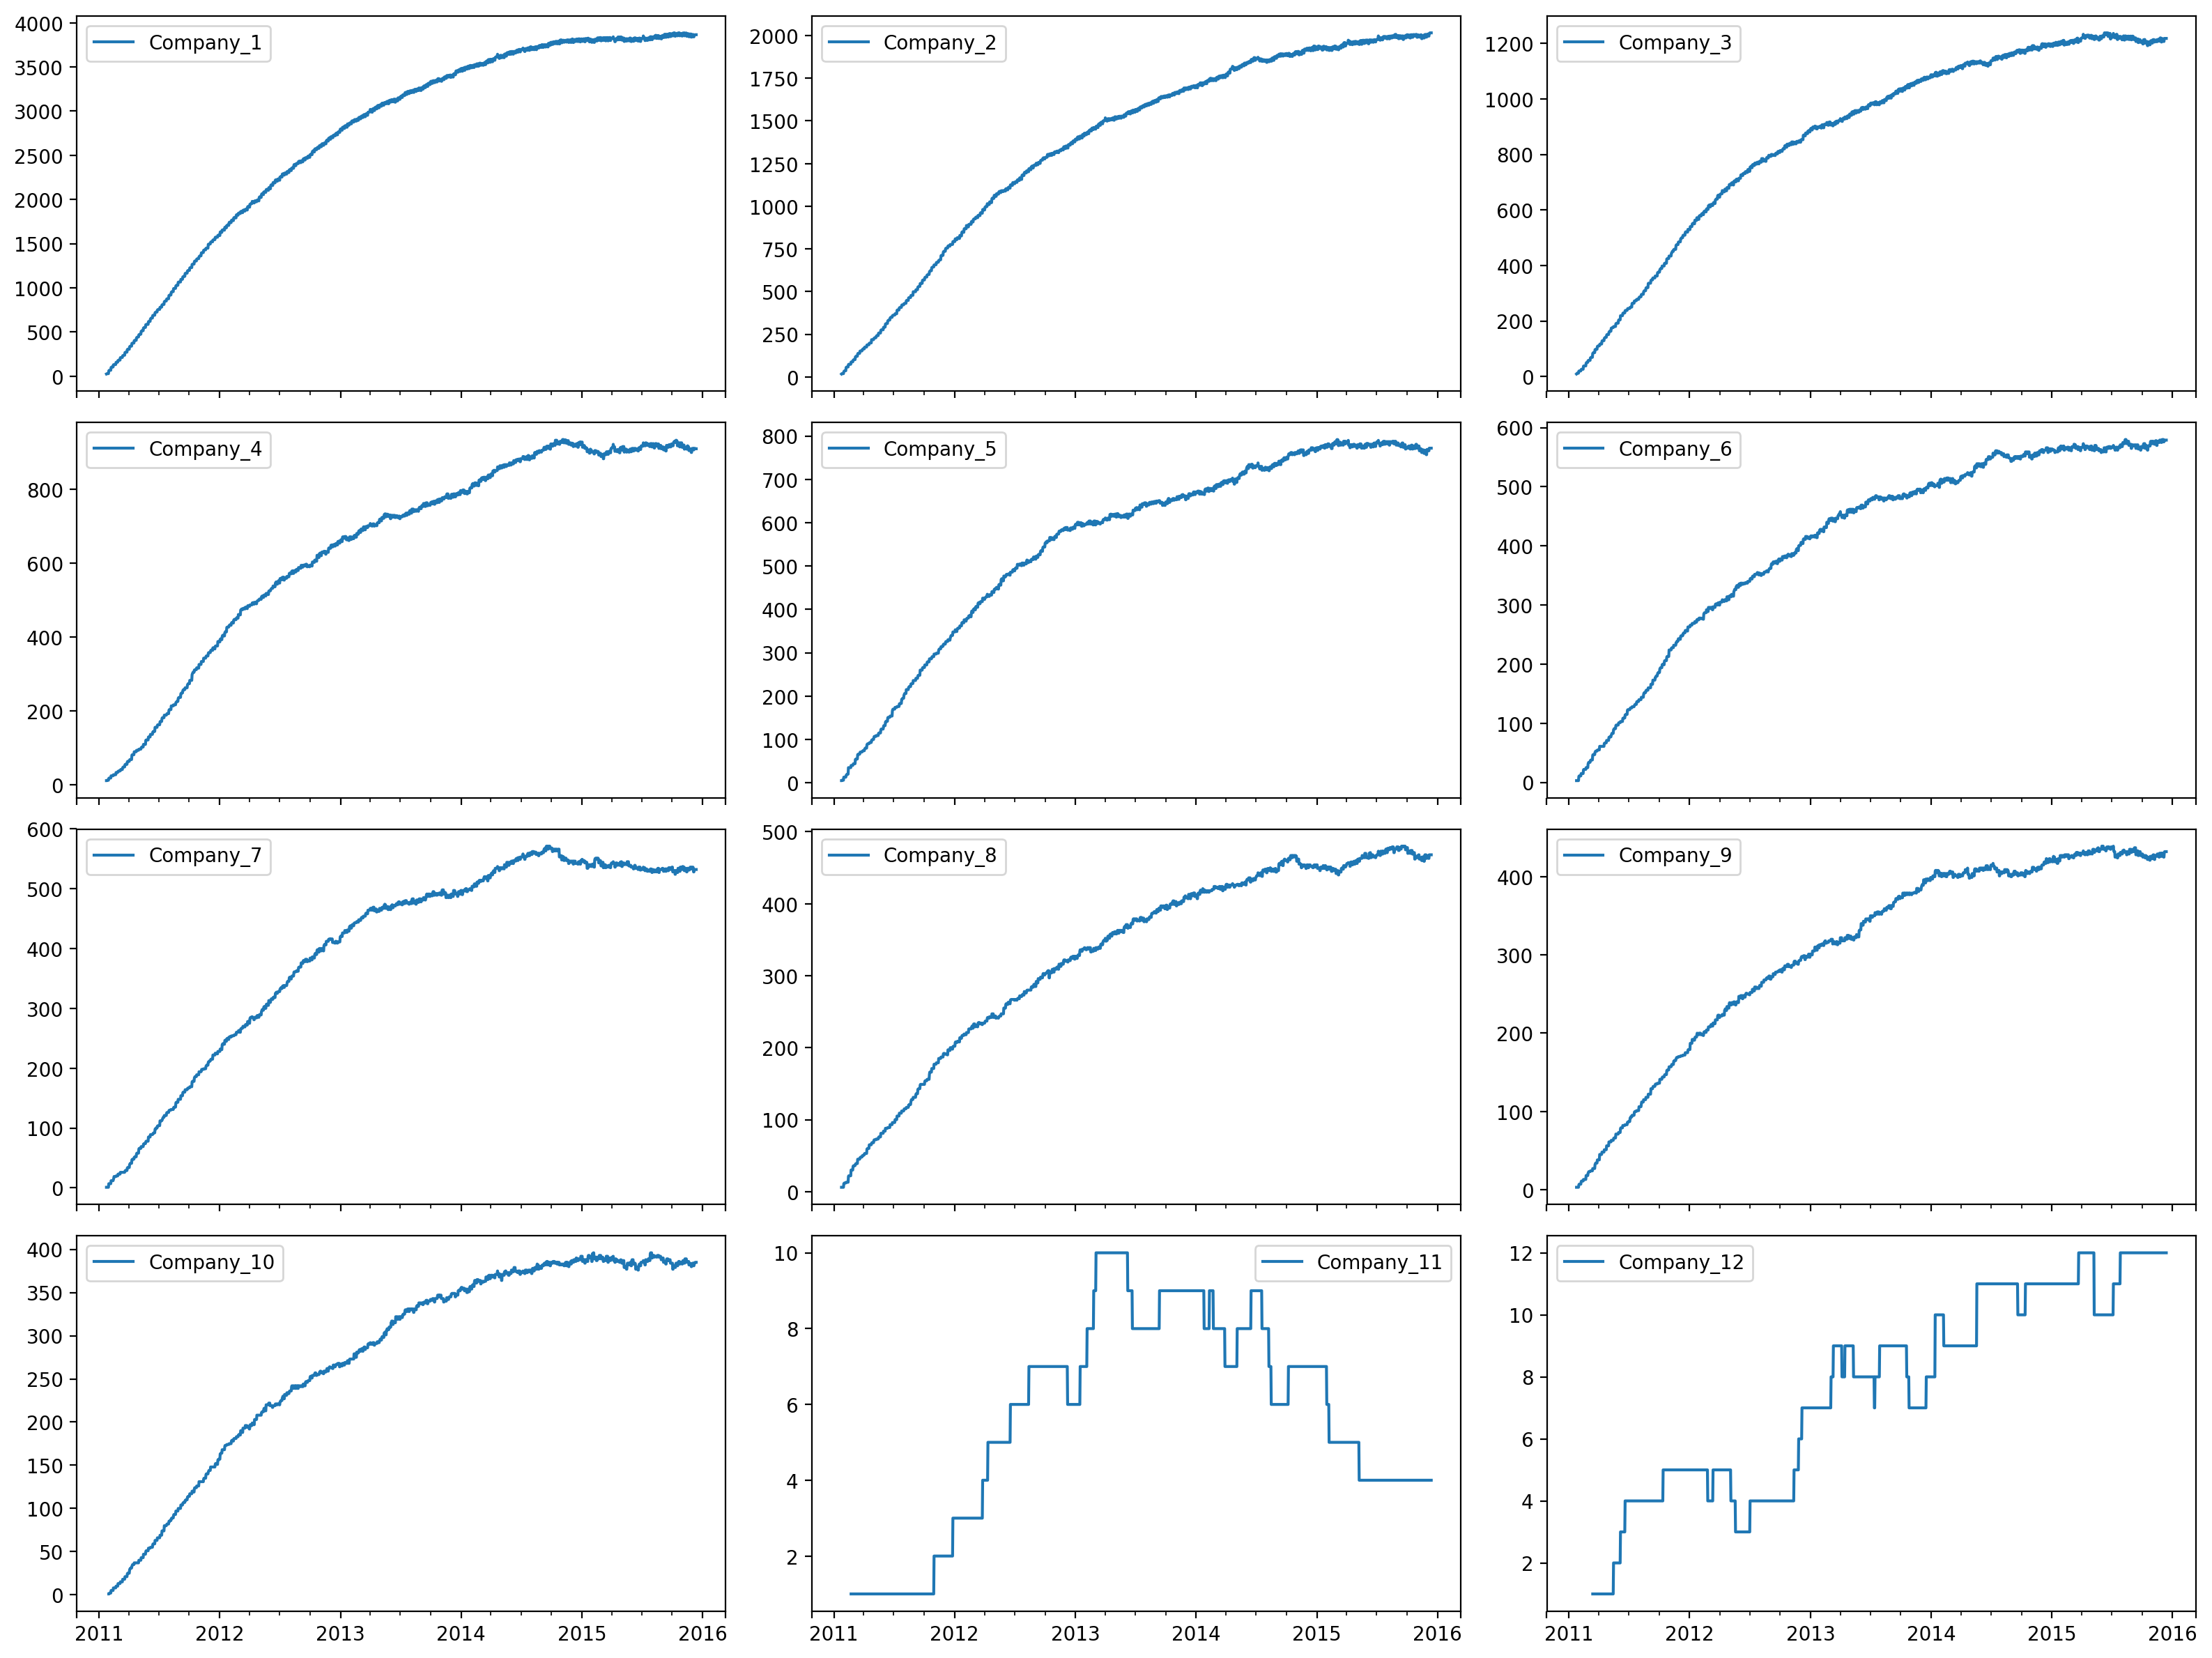

In [24]:
plts, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, dpi=200)
for i in company_headcount.keys():
    company_headcount[i]['head_count'].plot(ax = axes[(i-1)//3][(i-1)%3], label="Company_"+str(i), legend=True)
    
plt.tight_layout()

# 30-day attrition rate

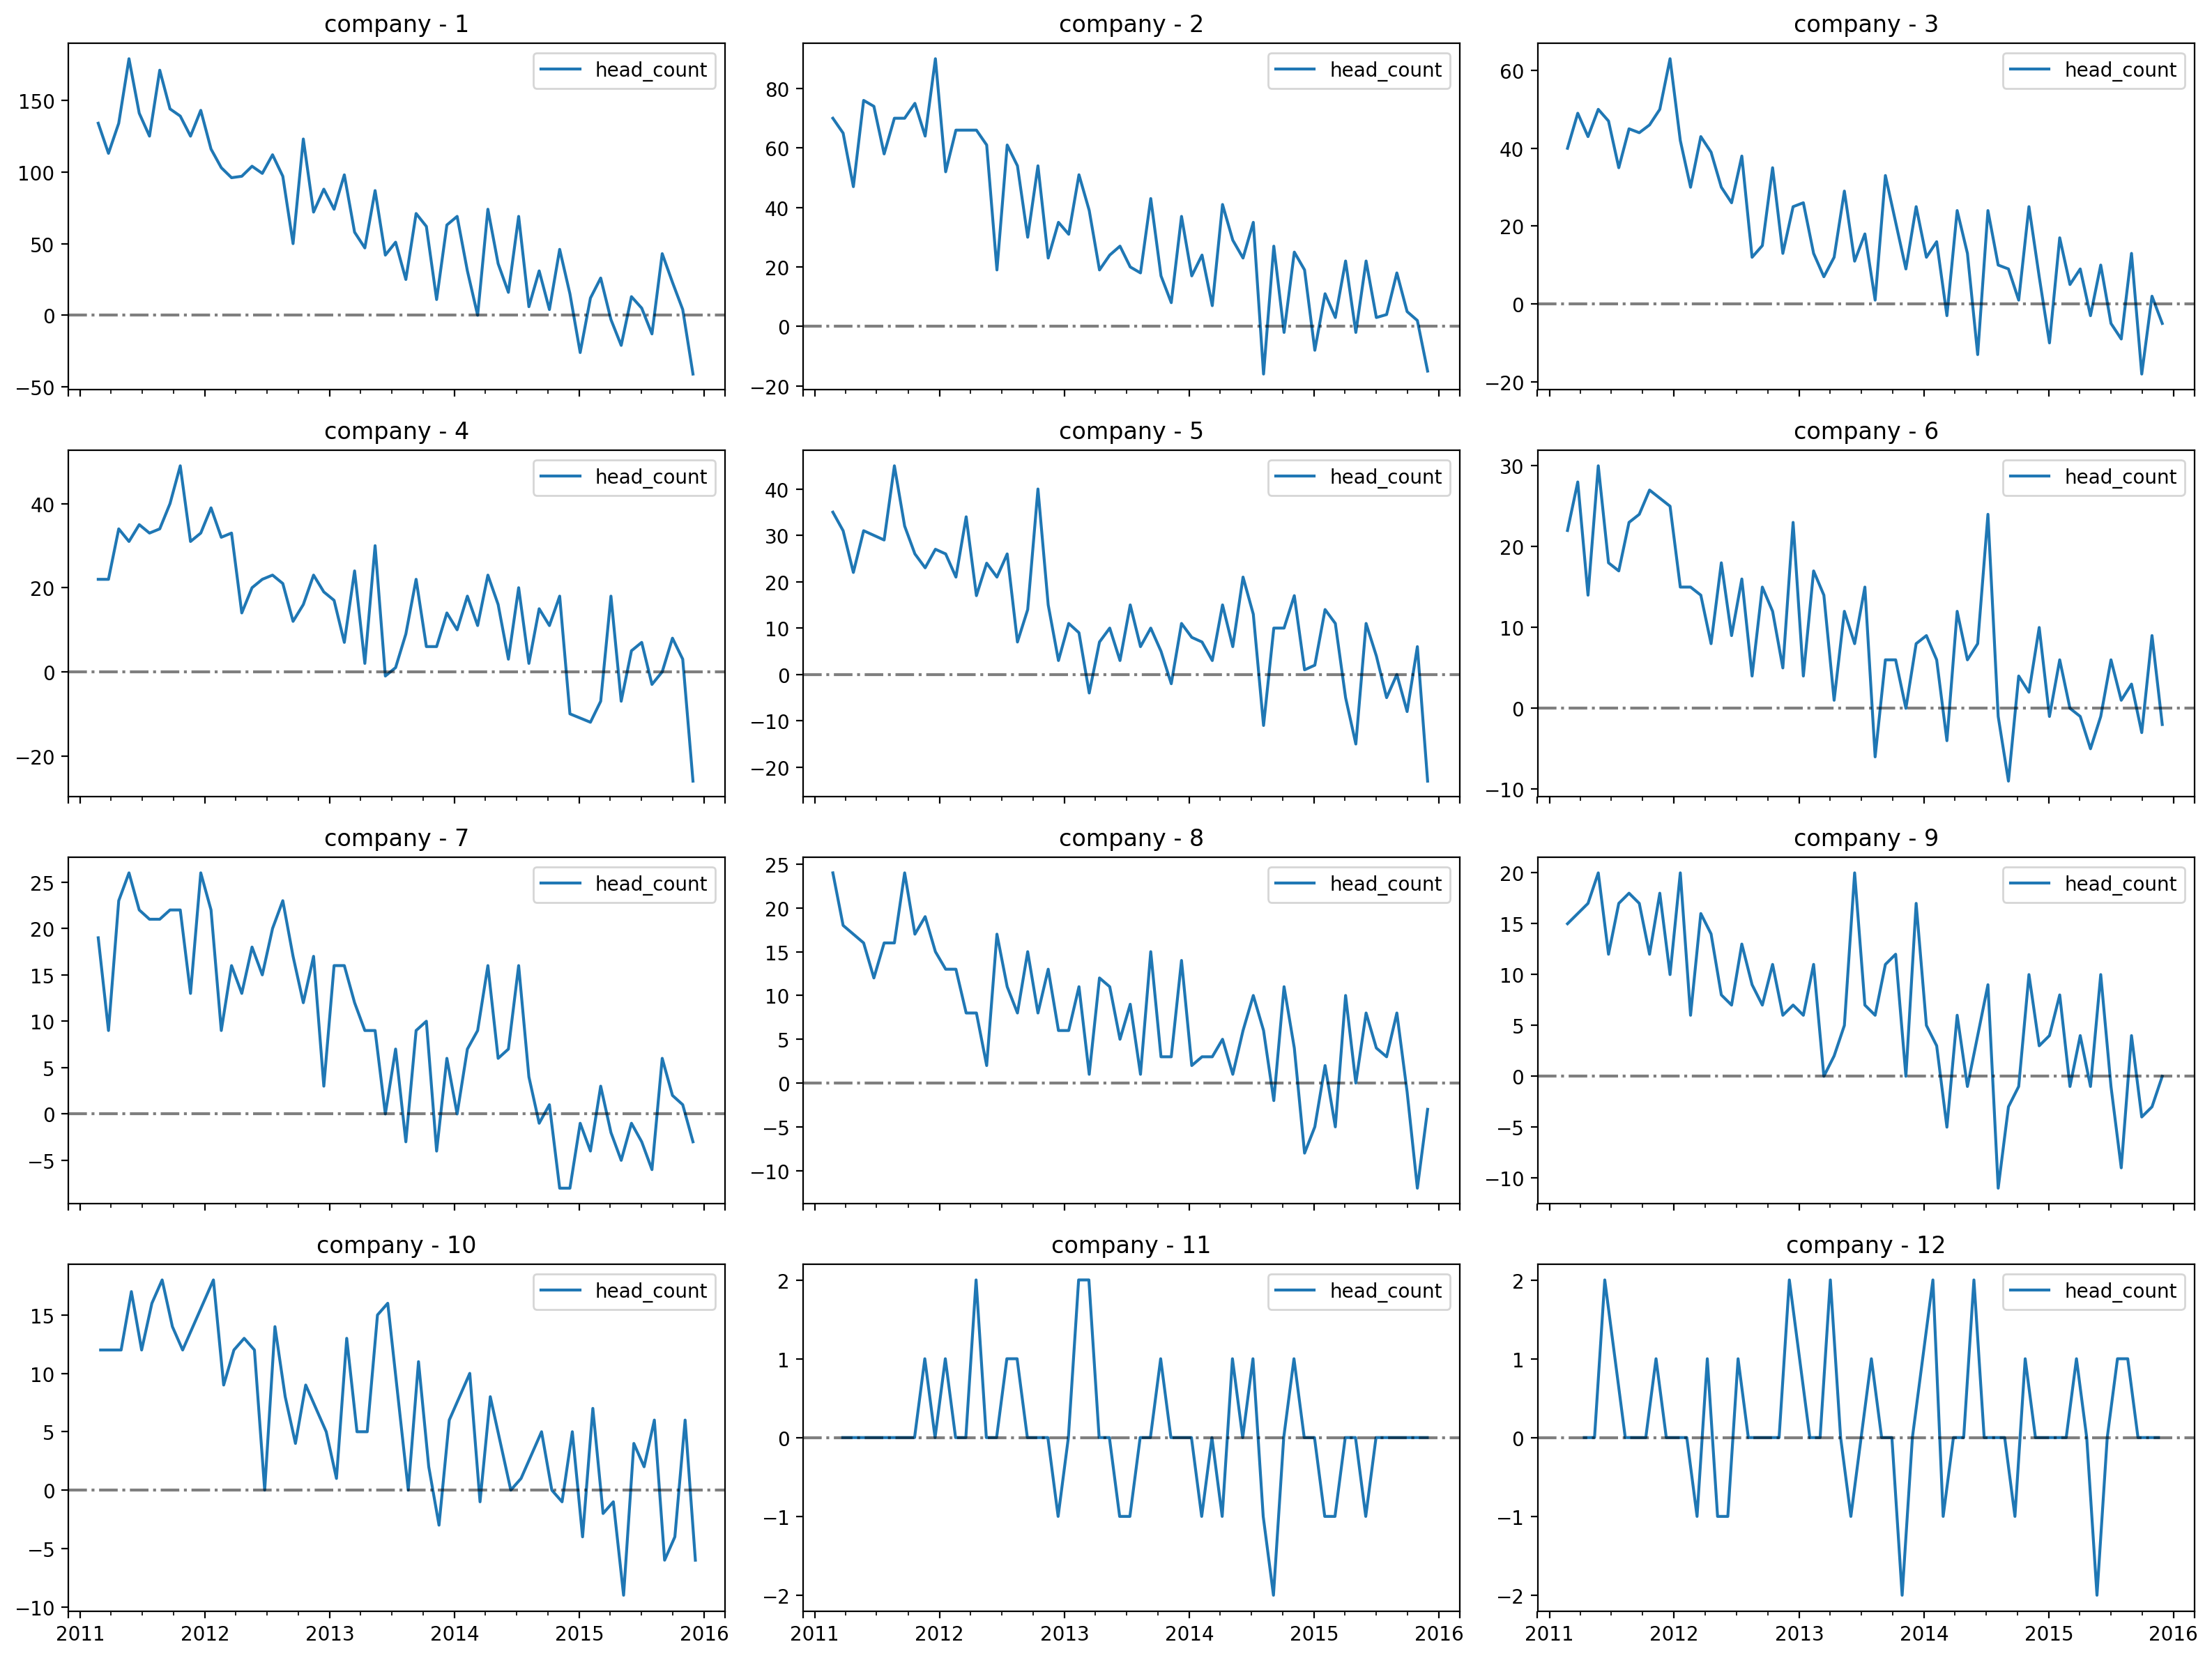

In [25]:
plts, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, dpi=200)
for i in company_headcount.keys():
    company_headcount[i].resample('30D').first().diff().plot(ax = axes[(i-1)//3][(i-1)%3])
    axes[(i-1)//3][(i-1)%3].set_title("company - %s" %str(i))
    axes[(i-1)//3][(i-1)%3].axhline(0, color='black', linestyle='-.', alpha=0.5)
    
plt.tight_layout()

# 90-day attrition rate

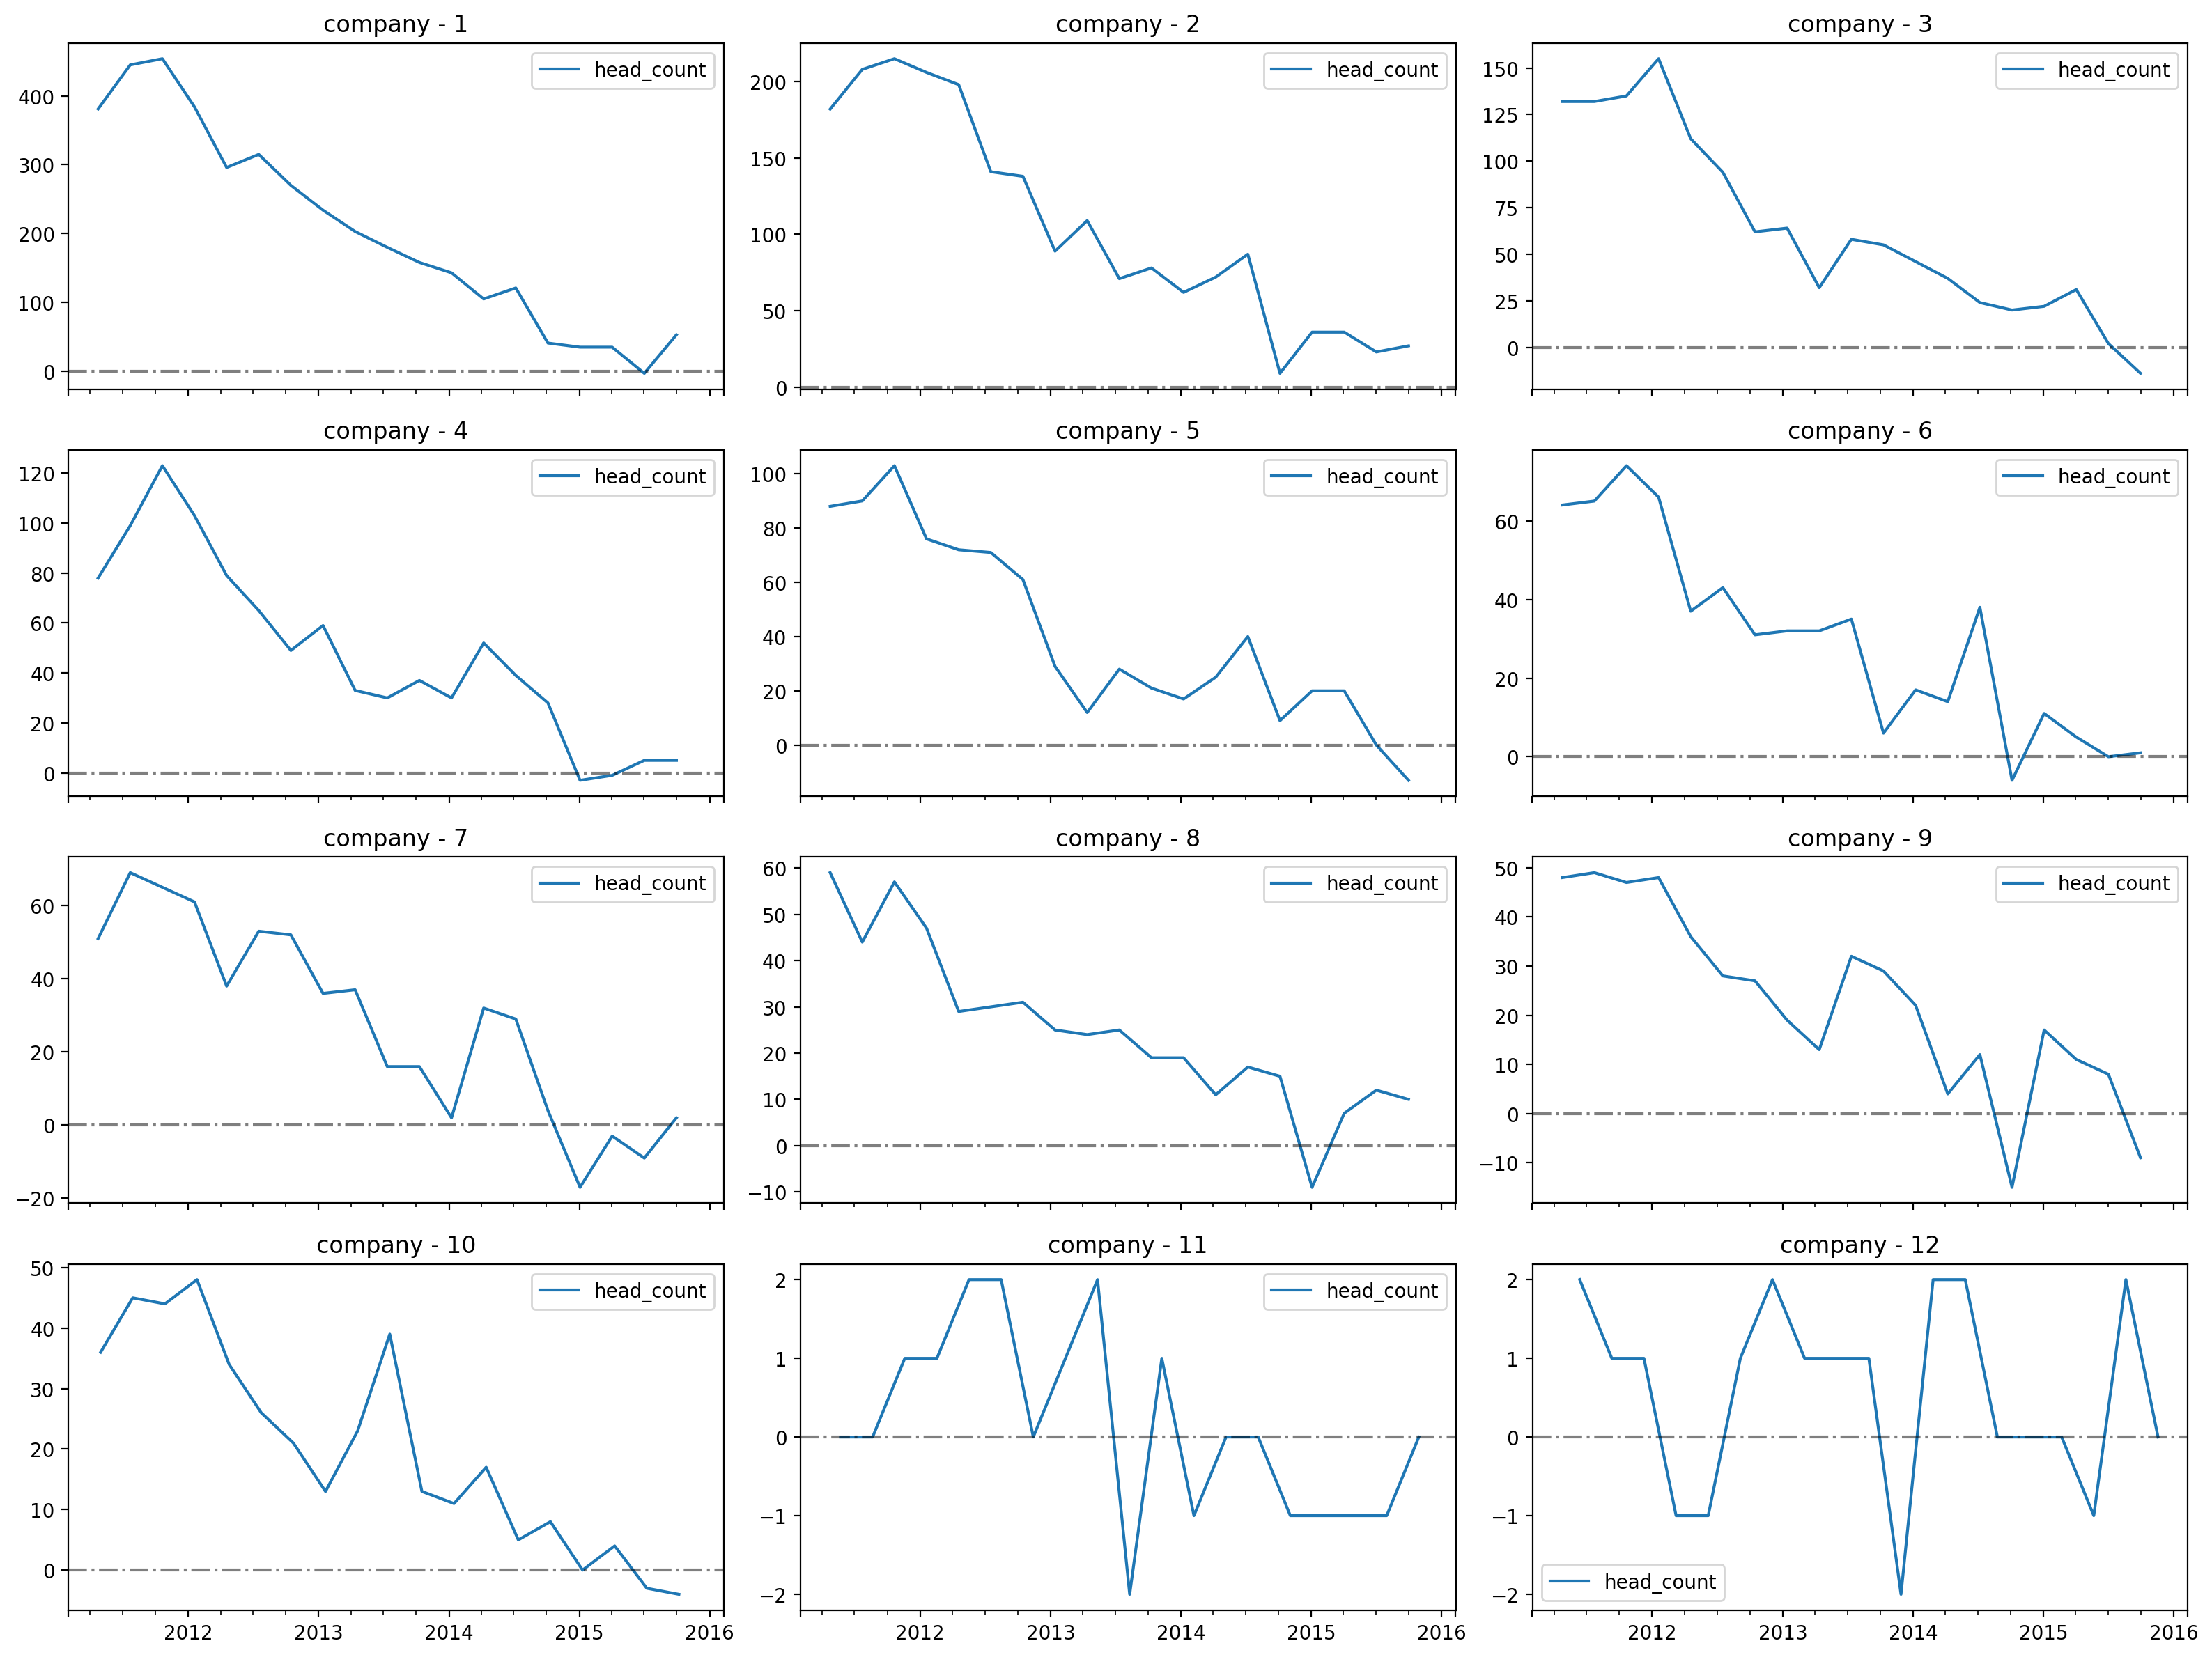

In [26]:
plts, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, dpi=200)
for i in company_headcount.keys():
    company_headcount[i].resample('90D').first().diff().plot(ax = axes[(i-1)//3][(i-1)%3])
    axes[(i-1)//3][(i-1)%3].set_title("company - %s" %str(i))
    axes[(i-1)//3][(i-1)%3].axhline(0, color='black', linestyle='-.', alpha=0.5)
    
plt.tight_layout()

The 30-day and 90-day attrition rate shows the change in the employees count for each company. A positive value represents more people are hired than churned and a negative value represents more employees are churned than hired. Similarly, an upward trend shows that increased number of employees are hired over the period than churned and vice versa. 

The 30-day attrition rate is chaotic to draw any conclusion. From the 90-day attrition rate analysis, the attrition rates for the company-1 and company-2 are always positive which means the hiring rate is always higher than churn rate whereas for other companies it has become negative .

# Main factor that drive employee churn?

Before going for modeling it important to prepare data for modeling by converting catergorical and nominal values to additional columns with binary values (create dummies) and normalize the data to make the model converge faster.

In [27]:
data['end_date'] = data['quit_date']
data.loc[data['quit_date'].isnull(), 'end_date'] = pd.to_datetime("2015/12/13")

In [28]:
data['duration_days'] = data['end_date'] - data['join_date']
data['week_year'] = [x.week for x in data['end_date']]
data['duration_years'] = [x.days/365 for x in data['duration_days']]

In [29]:
data['employee_id'] = data['employee_id'].astype(int)
data = data.set_index('employee_id', drop=True)

data.head()

,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years,end_date,week_year
employee_id,,,,,,,,,,,
13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585 days,1.602740,2015-10-30,44
825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340 days,0.931507,2014-04-04,14
927315,4,marketing,14,101000.0,2014-10-13,NaT,1,426 days,1.167123,2015-12-13,50
662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389 days,1.065753,2013-06-07,23
256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040 days,2.849315,2014-08-22,34


For the values in company_id and dept columns, new columns (binary) needs to created. We will do this step just before modeling or last step in data transformation. 

In [30]:
data_transformed = data.copy(deep=True)

### 1. Normalize salary

In [31]:
## Data Engineering
mean_salary_dept_company = data.groupby(['dept', 'seniority', 'company_id'])['salary'].mean().reset_index()
mean_salary_dept_company.head()

,dept,seniority,company_id,salary
0,customer_service,1,1,30356.521739
1,customer_service,1,2,29782.608696
2,customer_service,1,3,23666.666667
3,customer_service,1,4,23482.758621
4,customer_service,1,5,23772.727273


The mean salary for the same position is different across companies and taking this into consideration for our analysis, lets nomalize the salary based on the maximum salary offered for the position (same seniority and dept.)

In [32]:
for i, row in mean_salary_dept_company.iterrows():
    
    dept_ = row['dept']
    seniority_ = row['seniority']
    company_id_ = row['company_id']
    
    df_temp = data_transformed.loc[(data_transformed['dept']==dept_)&
                                   (data_transformed['seniority']==seniority_)&
                                   (data_transformed['company_id']==company_id_), 'salary'] / row['salary']
    
    data_transformed.loc[(data_transformed['dept']==dept_)&
                         (data_transformed['seniority']==seniority_)&
                         (data_transformed['company_id']==company_id_), 'salary'] = df_temp    

In [33]:
data_transformed.head()

,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years,end_date,week_year
employee_id,,,,,,,,,,,
13021,7,customer_service,28,0.949840,2014-03-24,2015-10-30,0,585 days,1.602740,2015-10-30,44
825355,7,marketing,20,1.118582,2013-04-29,2014-04-04,0,340 days,0.931507,2014-04-04,14
927315,4,marketing,14,0.983310,2014-10-13,NaT,1,426 days,1.167123,2015-12-13,50
662910,7,customer_service,20,1.188764,2012-05-14,2013-06-07,0,389 days,1.065753,2013-06-07,23
256971,2,data_science,23,0.907193,2011-10-17,2014-08-22,0,1040 days,2.849315,2014-08-22,34


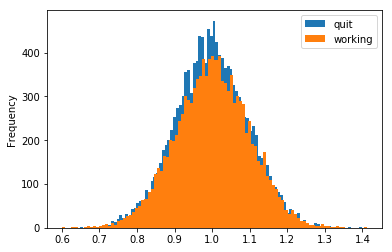

In [34]:
data_transformed.loc[data_transformed['job_status']==0, 'salary'].plot.hist(bins=100, label='quit', legend=True)
data_transformed.loc[data_transformed['job_status']==1, 'salary'].plot.hist(bins=100, label='working', legend=True)

By simply looking at the distribution of salaries across various departments and companies for the employee who quit and continued working, there is no significant diffference between the two. Hence, most likely salary will not be an important parameter in determining the employee churn.

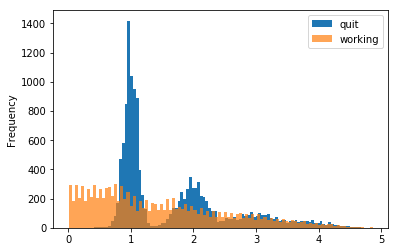

In [35]:
data_transformed.loc[data_transformed['job_status']==0, 'duration_years'].plot.hist(bins=100, label='quit', legend=True)
data_transformed.loc[data_transformed['job_status']==1, 'duration_years'].plot.hist(bins=100, label='working', alpha=0.7, legend=True)

The above plot shows an interesting trend. Employees usually want to quit when they are around 1, 2, 3, or 4 years of experience. This is probably due to vesting of stock options. The stocks options offered to employees gets vested by x% at the end of each year of experience. The employees who quit after 1 year of experience are early quitter who just want to cash out the first chunk of vested stocks and leave the company.

On the other hand, as expected, there is no interesting pattern for the employees who continued to work.

Awesome! This looks like a good predictor of churn.

### No. of. employees quit based on week of the year

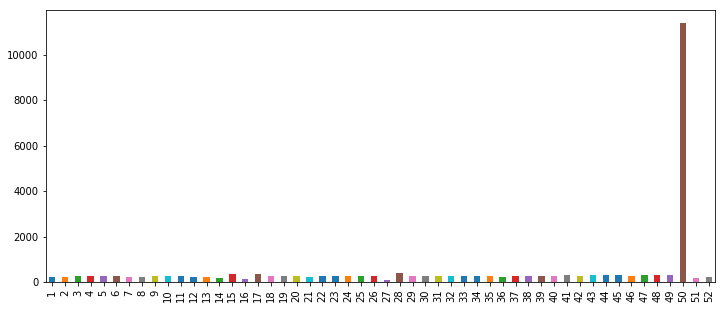

In [52]:
data_transformed['week_year'].value_counts().sort_index().plot.bar(figsize=(12, 5))

Interesting!! There are significantly large % of employees quit during the 50th week (end of the year). This is mainly because companies have entire fund available for hiring from the beginning of the year and tend to hire more people probably with lavish offers than what they would offer for the same position at the year end.

This also could be an important predictor for the target variable.

## Data transformations - for modeling

In [60]:
data_transformed.head()

,company_id,dept,seniority,salary,join_date,quit_date,job_status,duration_days,duration_years,end_date,week_year
employee_id,,,,,,,,,,,
13021,7,customer_service,28,0.949840,2014-03-24,2015-10-30,0,585 days,1.602740,2015-10-30,44
825355,7,marketing,20,1.118582,2013-04-29,2014-04-04,0,340 days,0.931507,2014-04-04,14
927315,4,marketing,14,0.983310,2014-10-13,NaT,1,426 days,1.167123,2015-12-13,50
662910,7,customer_service,20,1.188764,2012-05-14,2013-06-07,0,389 days,1.065753,2013-06-07,23
256971,2,data_science,23,0.907193,2011-10-17,2014-08-22,0,1040 days,2.849315,2014-08-22,34


In [61]:
data_transformed.drop(['join_date', 'quit_date', 'duration_days', 'end_date'], axis=1, inplace=True)
data_transformed.head()

,company_id,dept,seniority,salary,job_status,duration_years,week_year
employee_id,,,,,,,
13021,7,customer_service,28,0.949840,0,1.602740,44
825355,7,marketing,20,1.118582,0,0.931507,14
927315,4,marketing,14,0.983310,1,1.167123,50
662910,7,customer_service,20,1.188764,0,1.065753,23
256971,2,data_science,23,0.907193,0,2.849315,34


In [62]:
companyid_dummy = pd.get_dummies(data_transformed['company_id'])
dept_dummy = pd.get_dummies(data_transformed['dept'])

#default variables
companyid_dummy.drop(1, axis=1, inplace=True)
dept_dummy.drop("sales", axis=1, inplace=True)

data_transformed.drop(['company_id', 'dept'], axis=1, inplace=True)
data_transformed = pd.concat([data_transformed, companyid_dummy, dept_dummy], axis=1)

In [63]:
data_transformed.head()

,seniority,salary,job_status,duration_years,week_year,2,3,4,5,6,...,8,9,10,11,12,customer_service,data_science,design,engineer,marketing
employee_id,,,,,,,,,,,,,,,,,,,,,
13021,28,0.949840,0,1.602740,44,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
825355,20,1.118582,0,0.931507,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
927315,14,0.983310,1,1.167123,50,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
662910,20,1.188764,0,1.065753,23,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
256971,23,0.907193,0,2.849315,34,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Machine Learning Models

In [66]:
data_modeling = data_transformed.copy()

We are not simply interested in building an accurate model whereas we also need to know which parameters mainly contributing to the employee churn. For that there are 2 methods (not necessarily models) I can think of are 

(i) Ensemble methods that directly gives feature importances but requires huge amount of data and <br>
(ii) Backward elimination technique (or forward selection technique), with any classification technique, that retains only important variables.

In [64]:
data_transformed.count() / data_transformed.shape[0]

seniority           1.0
salary              1.0
job_status          1.0
duration_years      1.0
week_year           1.0
2                   1.0
3                   1.0
4                   1.0
5                   1.0
6                   1.0
7                   1.0
8                   1.0
9                   1.0
10                  1.0
11                  1.0
12                  1.0
customer_service    1.0
data_science        1.0
design              1.0
engineer            1.0
marketing           1.0
dtype: float64

In [65]:
print(data_transformed.shape)

(24700, 21)


So we have 35 columns

In [67]:
print(data_modeling.columns)

Index([       'seniority',           'salary',       'job_status',
         'duration_years',        'week_year',                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12, 'customer_service',     'data_science',
                 'design',         'engineer',        'marketing'],
      dtype='object')


In [68]:
cols_predictors = list(set(data_modeling.columns) - set(['job_status']))

In [69]:
data_modeling_X = data_modeling[cols_predictors].copy(deep=True)
data_modeling_X = data_modeling_X.values.reshape(-1, len(cols_predictors))

data_modeling_y = data_modeling[['job_status']].copy(deep=True)
data_modeling_y = data_modeling_y.values.reshape(-1, 1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data_modeling_X, data_modeling_y, test_size = 0.3,
                                                    train_size = 0.7, random_state = int(dt.datetime.now().second))

## 1. Logistic regression:

In [73]:
from sklearn.linear_model import LogisticRegression as LR

In [74]:
lr = LR(n_jobs=-1)

In [75]:
lr.fit(X_train, y_train)

C:\Users\venki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\venki\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
lr.score(X_test, y_test)

0.94534412955465585

In [83]:
probs = lr.predict_proba(X_test)
probs

array([[  2.11313764e-01,   7.88686236e-01],
       [  1.03270660e-01,   8.96729340e-01],
       [  1.00000000e+00,   9.92586145e-11],
       ..., 
       [  1.05722576e-01,   8.94277424e-01],
       [  1.29984970e-01,   8.70015030e-01],
       [  1.24991731e-01,   8.75008269e-01]])

In [84]:
fpr_lr, tpr_lr, thresh = roc_curve(y_test, probs[:, 1])

In [85]:
fold_auc_lr = auc(fpr_lr, tpr_lr)
fold_auc_lr

0.96554146408142161

-----------------------

### 2. Random Forest Classifier:

In [95]:
RFC = rfc(n_estimators=1000, n_jobs=-1, max_depth=5, min_samples_split=4, verbose=1, random_state = int(dt.datetime.now().second))

In [96]:
RFC.fit(X_train, y_train)

C:\Users\venki\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=51, verbose=1, warm_start=False)

In [97]:
RFC.score(X_test, y_test)

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.98340080971659916

<b> Clearly, the model is overfit. Lets remove the parameters that are less important

In [98]:
df_output = pd.DataFrame(RFC.feature_importances_, index = cols_predictors, columns=['Importance'])
df_output = df_output.sort_values('Importance', ascending=False)
df_output['Importance'] = ["{:.3f}".format(x) for x in df_output['Importance']]
df_output

,Importance
week_year,0.764
duration_years,0.224
seniority,0.004
salary,0.003
engineer,0.001
data_science,0.001
2,0.000
marketing,0.000
customer_service,0.000
4,0.000


In [100]:
df_output.index[:4].values

array(['week_year', 'duration_years', 'seniority', 'salary'], dtype=object)

In [101]:
probs = RFC.predict_proba(X_test)
probs

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


array([[ 0.87097024,  0.12902976],
       [ 0.23016245,  0.76983755],
       [ 0.88586582,  0.11413418],
       ..., 
       [ 0.27270748,  0.72729252],
       [ 0.26456969,  0.73543031],
       [ 0.23476556,  0.76523444]])

In [102]:
fpr_rfc_all, tpr_rfc_all, thresh = roc_curve(y_test, probs[:, 1])

In [103]:
fold_auc_rfc_all = auc(fpr_rfc_all, tpr_rfc_all)
fold_auc_rfc_all

0.99720106651709162

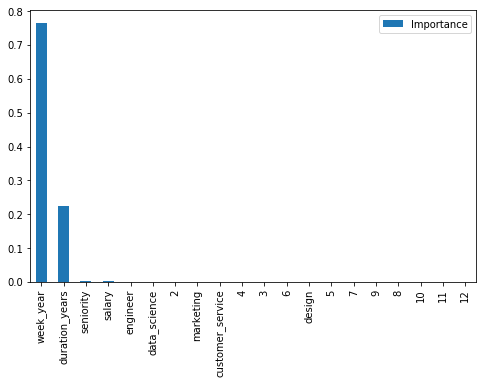

In [104]:
pd.DataFrame(RFC.feature_importances_, index = cols_predictors,
             columns=['Importance']).sort_values("Importance", ascending=False).plot.bar(figsize=(8, 5))

<b> Train again with top 4 most important parameters

In [105]:
# Using only top 5 parameters
cols_predictors = df_output.index[:4].values

In [106]:
data_modeling_X = data_modeling[cols_predictors].copy(deep=True)
data_modeling_X = data_modeling_X.values.reshape(-1, len(cols_predictors))

data_modeling_y = data_modeling[['job_status']].copy(deep=True)
data_modeling_y = data_modeling_y.values.reshape(-1, 1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(data_modeling_X, data_modeling_y, test_size = 0.3,
                                                    train_size = 0.7, random_state = int(dt.datetime.now().second))

In [108]:
RFC = rfc(n_estimators=1000, n_jobs=-1, random_state=0)

In [109]:
RFC.fit(X_train, y_train)

C:\Users\venki\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [110]:
RFC.score(X_test, y_test)

0.99149797570850207

<b> Score further improved

In [867]:
df_out = pd.DataFrame(RFC.feature_importances_, index = cols_predictors, columns=['Importance'])
df_out = df_out.sort_values('Importance', ascending=False)
df_out

,Importance
duration_years,0.631854
salary,0.254955
seniority,0.101323
data_science,0.006168
engineer,0.005699


In [111]:
probs = RFC.predict_proba(X_test)

fpr_rfc_4, tpr_rfc_4, thresh = roc_curve(y_test, probs[:, 1])
fold_auc_rfc_4 = auc(fpr_rfc_4, tpr_rfc_4)

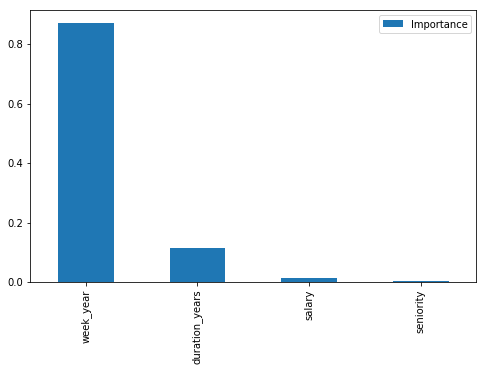

In [112]:
pd.DataFrame(RFC.feature_importances_, index = cols_predictors,
             columns=['Importance']).sort_values("Importance", ascending=False).plot.bar(figsize=(8, 5))

<b> Train again with top 3 most important parameters

In [113]:
# Using only top 2 parameters
cols_predictors = df_output.index[:2].values

In [114]:
data_modeling_X = data_modeling[cols_predictors]
data_modeling_y = data_modeling[['job_status']]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data_modeling_X, data_modeling_y, test_size = 0.3, train_size = 0.7,
                                                    random_state = int(dt.datetime.now().second))

In [116]:
RFC = rfc(n_estimators=1000, n_jobs=-1)

In [117]:
RFC.fit(X_train, y_train)

C:\Users\venki\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
RFC.score(X_test, y_test)

0.99028340080971655

In [119]:
pd.DataFrame(RFC.feature_importances_, index = X_train.columns, columns=['Importance'])

,Importance
week_year,0.850568
duration_years,0.149432


In [120]:
probs = RFC.predict_proba(X_test)

fpr_rfc_2, tpr_rfc_2, thresh = roc_curve(y_test, probs[:, 1])
fold_auc_rfc_2 = auc(fpr_rfc_2, tpr_rfc_2)
fold_auc_rfc_2

0.99840121851722996

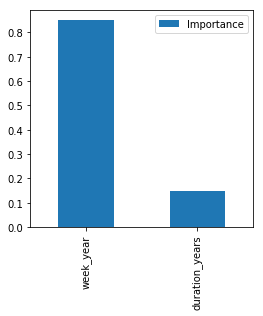

In [123]:
pd.DataFrame(RFC.feature_importances_, index = ['week_year', 'duration_years'],
             columns=['Importance']).sort_values("Importance", ascending=False).plot.bar(figsize=(4, 4))

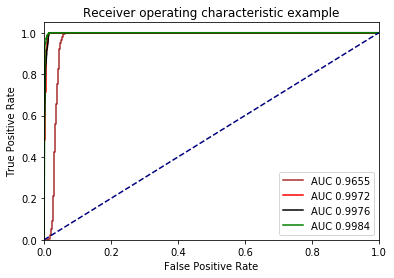

In [126]:
plt.plot(fpr_lr, tpr_lr, label="AUC {:.4f}".format(fold_auc_lr), color='brown')
plt.plot(fpr_rfc_all, tpr_rfc_all, label="AUC {:.4f}".format(fold_auc_rfc_all), color='red')
plt.plot(fpr_rfc_4, tpr_rfc_4, label="AUC {:.4f}".format(fold_auc_rfc_4), color='black')
plt.plot(fpr_rfc_2, tpr_rfc_2, label="AUC {:.4f}".format(fold_auc_rfc_2), color='green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Among the models developed, the one with top 2 important variables is the most accurate and reliable model for predicting churn.

## Partial Dependence plots

Now that we know that 'week_day' and the 'duration_years' are the most important predictors, it is also important to know how they impact or influence the target variable.

For that lets use "partial dependance plots". The partial dependance plots are the best way to intrepret how each parameters affects/influences the target variable.

In [127]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [129]:
from sklearn.ensemble import GradientBoostingClassifier as gbc

In [130]:
gbc_ = gbc()

In [131]:
gbc_.fit(X_train, y_train)

C:\Users\venki\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [132]:
gbc_.score(X_test, y_test)

0.99203778677462884

In [136]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5,0,'Partial dependence')

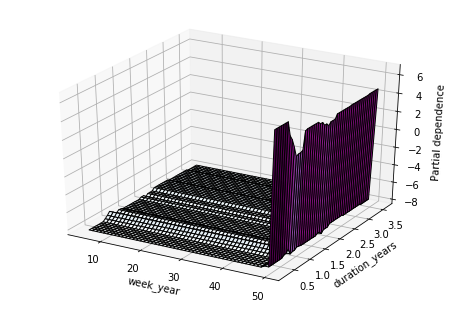

In [138]:
fig = plt.figure()

pdp, axes = partial_dependence(gbc_, (0, 1), X=X_train, grid_resolution=50)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')

ax.set_xlabel('week_year')
ax.set_ylabel('duration_years')
ax.set_zlabel('Partial dependence')

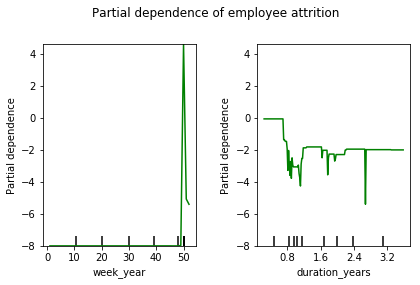

In [150]:
features = [0, 1]
fig, axs = plot_partial_dependence(gbc_, X_train, features, n_jobs=-1, grid_resolution=200)

axs[0].set_xlabel("week_year")
axs[1].set_xlabel("duration_years")
fig.suptitle('Partial dependence of employee attrition')
plt.subplots_adjust(top=0.85)

As expected, the partial dependence for the 'week_year' is high only for the week 50 which is important for the model. For 'duration_years' plot, the partial dependance dips for the year 1 and 2 and almost negligible for the other years. These are the indicators on which our model relies on and how it predicts the target value.

# What was the most important variable?

The most important variable turned out to be __week of the year ("week_year")__ the employees quit which was not explicity given in the dataset. This proves that Data engineering is one of the most important steps in building predictive models.

-------------